In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

In [23]:
#Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
dataset_choice=input("Choose dataset b/w mnist or fashion: ")       # "mnist" or "fashion"
epochs=int(input("Epochs b/w 30 to 50: "))
batch_size=int(input("Batch size b/w 64 to 128: "))
noise_dim=int(input("Noise dimension b/w 50 to 100: "))
learning_rate=float(input("Learning rate eg. 0.00002: "))
save_interval=int(input("Save interval eg. 5: "))

Choose dataset b/w mnist or fashion:  fashion
Epochs b/w 30 to 50:  50
Batch size b/w 64 to 128:  64
Noise dimension b/w 50 to 100:  80
Learning rate eg. 0.00002:  0.0002
Save interval eg. 5:  5


In [25]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1,1]
])

if dataset_choice == "mnist":
    dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
elif dataset_choice == "fashion":
    dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
else:
    raise ValueError("Invalid dataset choice")

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
image_shape = (1, 28, 28)

100%|█████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:04<00:00, 6.19MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 148kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:02<00:00, 1.50MB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 5.47MB/s]


In [26]:
#Generator Network
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(z.size(0), *image_shape)

In [27]:
#Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

In [28]:
#Initialize Models & Optimizers
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

In [29]:
os.makedirs("generated_samples", exist_ok=True)
os.makedirs("final_generated_images", exist_ok=True)

In [30]:
for epoch in range(1, epochs + 1):
    d_loss_total, g_loss_total = 0, 0
    correct, total = 0, 0

    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size_curr = real_imgs.size(0)

        real_labels = torch.ones(batch_size_curr, 1).to(device)
        fake_labels = torch.zeros(batch_size_curr, 1).to(device)

        # Train Discriminator
        z = torch.randn(batch_size_curr, noise_dim).to(device)
        fake_imgs = generator(z)

        real_loss = criterion(discriminator(real_imgs), real_labels)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Accuracy
        preds = (discriminator(real_imgs) > 0.5).float()
        correct += preds.sum().item()
        total += batch_size_curr

        # Train Generator
        g_loss = criterion(discriminator(fake_imgs), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        d_loss_total += d_loss.item()
        g_loss_total += g_loss.item()

    d_acc = (correct / total) * 100

    print(f"Epoch {epoch}/{epochs} | D_loss: {d_loss_total:.2f} | D_acc: {d_acc:.2f}% | G_loss: {g_loss_total:.2f}")

    # Save samples
    if epoch % save_interval == 0:
        utils.save_image(fake_imgs[:25], f"generated_samples/epoch_{epoch:02d}.png",
                         nrow=5, normalize=True)

Epoch 1/50 | D_loss: 395.54 | D_acc: 94.57% | G_loss: 3111.13
Epoch 2/50 | D_loss: 171.15 | D_acc: 96.21% | G_loss: 5449.78
Epoch 3/50 | D_loss: 348.24 | D_acc: 92.49% | G_loss: 4990.14
Epoch 4/50 | D_loss: 384.04 | D_acc: 90.61% | G_loss: 3598.24
Epoch 5/50 | D_loss: 393.98 | D_acc: 90.38% | G_loss: 3513.03
Epoch 6/50 | D_loss: 484.27 | D_acc: 88.71% | G_loss: 3399.00
Epoch 7/50 | D_loss: 676.20 | D_acc: 82.21% | G_loss: 2687.72
Epoch 8/50 | D_loss: 655.70 | D_acc: 82.18% | G_loss: 2358.57
Epoch 9/50 | D_loss: 609.03 | D_acc: 83.35% | G_loss: 2483.77
Epoch 10/50 | D_loss: 639.69 | D_acc: 82.58% | G_loss: 2339.30
Epoch 11/50 | D_loss: 676.30 | D_acc: 81.22% | G_loss: 2369.69
Epoch 12/50 | D_loss: 662.78 | D_acc: 81.21% | G_loss: 2163.12
Epoch 13/50 | D_loss: 638.46 | D_acc: 82.40% | G_loss: 2352.82
Epoch 14/50 | D_loss: 784.52 | D_acc: 78.43% | G_loss: 2056.89
Epoch 15/50 | D_loss: 741.44 | D_acc: 78.96% | G_loss: 2002.66
Epoch 16/50 | D_loss: 810.95 | D_acc: 76.44% | G_loss: 1795.31
E

In [31]:
generator.eval()
z = torch.randn(100, noise_dim).to(device)
final_images = generator(z)

for i in range(100):
    utils.save_image(final_images[i],
                     f"final_generated_images/img_{i+1}.png",
                     normalize=True)

In [32]:
generator.eval()

noise_dim = 80  # must match training
num_images = 100

z = torch.randn(num_images, noise_dim).to(device)

final_images = generator(z)

print("final_images created with shape:", final_images.shape)


final_images created with shape: torch.Size([100, 1, 28, 28])


In [33]:
classifier = models.resnet18(pretrained=True)
classifier.fc = nn.Linear(512, 10)
classifier = classifier.to(device)
classifier.eval()

predicted_labels = []

for img in final_images:
    img = img.repeat(1, 3, 1, 1)  # convert 1-channel to 3-channel
    output = classifier(img.to(device))
    label = torch.argmax(output).item()
    predicted_labels.append(label)

labels, counts = np.unique(predicted_labels, return_counts=True)

print("Label Distribution of Generated Images:")
for l, c in zip(labels, counts):
    print(f"Label {l}: {c} images")


Label Distribution of Generated Images:
Label 2: 1 images
Label 4: 3 images
Label 8: 1 images
Label 9: 95 images


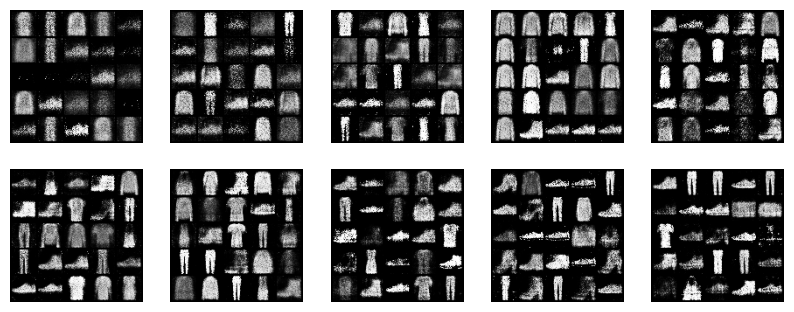

In [35]:
files = sorted(os.listdir("generated_samples"))

plt.figure(figsize=(10, 10))
for i, f in enumerate(files[:25]):
    img = Image.open(os.path.join("generated_samples", f))
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
plt.show()